In [1]:
%reset -f

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.modules.loss import _Loss
import os
import torchvision
from torchvision.io.image import ImageReadMode
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import random
from torch.utils.data import DataLoader
import tqdm
from typing import Callable
from enum import Enum
import math
import copy
import json
from datetime import datetime

torch.cuda.empty_cache()

In [2]:
def load_dataset() -> list[torch.Tensor]:
    images_dir:str = os.path.join(os.getcwd(), "Dataset", "64x64")
    images_path:list[str] = os.listdir(images_dir)
    images:list[torch.Tensor] = list[torch.Tensor]()

    for image_local_path in images_path:
        image_absolute_path:str = os.path.join(images_dir, image_local_path)
        image:torch.Tensor = torchvision.io.read_image(image_absolute_path, ImageReadMode.RGB).type(torch.float32) / 255.0
        image = image * 2.0 - 1.0 # Extend the image for the [-1, 1] range
        images.append(image)
    return images

dataset:list[torch.Tensor] = load_dataset()

In [3]:
def plot_dataset_image(nb_image:int) -> None:
    for _ in range(0, nb_image):
        index:int = random.randint(0, len(dataset) - 1)
        image:torch.Tensor = dataset[index] * 0.5 + 0.5
        image = image.permute(1, 2, 0)
        plt.imshow(image)
        plt.show()
        
#plot_dataset_image(1)

In [4]:
class UNetSetting:

    def __init__(self, in_channels:int=3, base_channels:int=64, time_emb_dim:int=256) -> None:
        self.in_channels:int = in_channels
        self.base_channels:int = base_channels
        self.time_emb_dim:int = time_emb_dim

#constant
image_size:int = dataset[0].shape[1]

# Model hyperparameters
beta_scheduler_start:float = 1e-4
beta_scheduler_end:float = 0.02

#training params
#constant
in_channels:int = 3
base_channels:int = 64
unet_setting = UNetSetting(in_channels, base_channels, 256)
batch_size:int = 48
timestep:int = 1000
ema_decay:float = 0.999 # might use 0.9999
epochs:int = 3000
test_proportion:float = 0.1

total_steps:int = epochs * (int(len(dataset) * (1.0 - test_proportion)) // batch_size)
warmup_steps:int = 1000  # you can go higher if you have small dataset
base_lr:float = 2e-3
def lr_scheduler_fn(step:int) -> float:
    return base_lr

# low lr at 0 -> warmup_steps steps, grows to 0.0002 and drop to 0 at the end of the training
lr_scheduler:Callable[[int], float] = lr_scheduler_fn

# To plot lr curve, uncomment the line below
# X:list[float] = [float(i) for i in range(0, total_steps)]
# Y:list[float] = [lr_scheduler_fn(i) for i in range(0, total_steps )]
# plt.plot(X, Y)
# plt.show()

saving_epoch_interval:int = 50
print_epoch_interval:int = 50
nb_sample_to_print:int = 1
device:str = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Device : {device}")

Device : cuda


In [5]:
def sinusoidal_embedding(timesteps:torch.Tensor, dim:int):
    """
    Create sinusoidal embeddings for timesteps.
    timesteps: (B,) tensor of integers
    dim: embedding dimension
    """
    device = timesteps.device
    half_dim = dim // 2
    emb = math.log(10000) / (half_dim - 1)
    emb = torch.exp(torch.arange(half_dim, device=device) * -emb)
    emb = timesteps[:, None] * emb[None, :]
    emb = torch.cat([torch.sin(emb), torch.cos(emb)], dim=1)
    return emb  # shape (B, dim)

class ResidualBlock(nn.Module):
    def __init__(self, in_channels:int, out_channels:int, time_emb_dim:int, dropout:float=0.0):
        super().__init__()
        self.norm1:nn.GroupNorm = nn.GroupNorm(8, in_channels)
        self.activation:nn.SiLU = nn.SiLU()
        self.conv1:nn.Conv2d = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        
        self.norm2:nn.GroupNorm= nn.GroupNorm(8, out_channels)
        self.conv2:nn.Conv2d = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        
        self.time_mlp:nn.Linear = nn.Linear(time_emb_dim, out_channels)
        self.dropout:nn.Dropout = nn.Dropout(dropout)

        self.res_conv:nn.Conv2d = nn.Conv2d(in_channels, out_channels, 1) if in_channels != out_channels else nn.Identity()

    def forward(self, x:torch.Tensor, t_emb:torch.Tensor) -> torch.Tensor:
        h:torch.Tensor = self.conv1(self.activation(self.norm1(x)))
        
        t_h:torch.Tensor = self.time_mlp(self.activation(t_emb))
        h = h + t_h[:, :, None, None]
        
        h = self.conv2(self.activation(self.norm2(h)))
        h = self.dropout(h)
        
        return h + self.res_conv(x)

class UNet(nn.Module):
    def __init__(self, in_channels:int=3, base_channels:int=64, time_emb_dim:int=256) -> None:
        super().__init__()
        
        self.time_mlp:nn.Sequential = nn.Sequential(
            nn.Linear(time_emb_dim, time_emb_dim * 4),
            nn.SiLU(),
            nn.Linear(time_emb_dim * 4, time_emb_dim)
        )

        self.conv_in:nn.Conv2d = nn.Conv2d(in_channels, base_channels, 3, padding=1)
        self.down1:ResidualBlock = ResidualBlock(base_channels, base_channels, time_emb_dim)
        self.down2:ResidualBlock = ResidualBlock(base_channels, base_channels*2, time_emb_dim)
        self.downsample1:nn.Conv2d = nn.Conv2d(base_channels*2, base_channels*2, 4, 2, 1)
        
        self.down3:ResidualBlock = ResidualBlock(base_channels*2, base_channels*2, time_emb_dim)
        self.down4:ResidualBlock = ResidualBlock(base_channels*2, base_channels*4, time_emb_dim)
        self.downsample2:nn.Conv2d = nn.Conv2d(base_channels*4, base_channels*4, 4, 2, 1)
        
        self.mid1:ResidualBlock = ResidualBlock(base_channels*4, base_channels*4, time_emb_dim)
        self.mid2:ResidualBlock = ResidualBlock(base_channels*4, base_channels*4, time_emb_dim)
        
        self.upsample1:nn.ConvTranspose2d = nn.ConvTranspose2d(base_channels*4, base_channels*4, 4, 2, 1)
        self.up1:ResidualBlock = ResidualBlock(base_channels*4 + base_channels*4, base_channels*2, time_emb_dim)
        
        self.upsample2 = nn.ConvTranspose2d(base_channels*2, base_channels*2, 4, 2, 1)
        self.up2:ResidualBlock = ResidualBlock(base_channels*2 + base_channels*2, base_channels, time_emb_dim)
        
        self.conv_out:nn.Conv2d = nn.Conv2d(base_channels, in_channels, 3, padding=1)

    def forward(self, x:torch.Tensor, t:torch.Tensor) -> torch.Tensor:
        t_emb:torch.Tensor = sinusoidal_embedding(t.long(), self.time_mlp[0].in_features)
        t_emb = self.time_mlp(t_emb)
        
        x1:torch.Tensor = self.conv_in(x)
        x2:torch.Tensor = self.down1(x1, t_emb)
        x3:torch.Tensor = self.down2(x2, t_emb)
        x4:torch.Tensor = self.downsample1(x3)
        
        x5:torch.Tensor = self.down3(x4, t_emb)
        x6:torch.Tensor = self.down4(x5, t_emb)
        x7:torch.Tensor = self.downsample2(x6)
        
        mid:torch.Tensor = self.mid1(x7, t_emb)
        mid = self.mid2(mid, t_emb)
        
        u1:torch.Tensor = self.upsample1(mid)
        u1 = torch.cat([u1, x6], dim=1)
        u1 = self.up1(u1, t_emb)
        
        u2:torch.Tensor = self.upsample2(u1)
        u2 = torch.cat([u2, x3], dim=1)
        u2 = self.up2(u2, t_emb)
        
        return self.conv_out(u2)

In [6]:
class DiffusionModel:
    def __init__(self, model:UNet, optimizer:torch.optim.Optimizer, criterion:_Loss, timesteps:int, device:str) -> None:
        self.model:UNet = model.to(device)
        self.optimizer:torch.optim.Optimizer = optimizer
        self.criterion:_Loss = criterion
        self.timesteps:int = timesteps
        self.device:str = device
        
        self.beta:torch.Tensor = self._linear_schedule()
        self.alpha:torch.Tensor = 1.0 - self.beta
        self.alpha_bar:torch.Tensor = torch.cumprod(self.alpha, dim=0)
        alpha_bar_prev:torch.Tensor = torch.cat([torch.tensor([1.0]), self.alpha_bar[:-1]])
        self.posterior_variance:torch.Tensor = self.beta * ((1 - alpha_bar_prev) / (1 - self.alpha_bar))

    def _linear_schedule(self):
        return torch.linspace(beta_scheduler_start, beta_scheduler_end, self.timesteps)
    
    def _cosine_schedule(self, s:float=0.008):
        steps:int = self.timesteps + 1
        x:torch.Tensor = torch.linspace(0, self.timesteps, steps)
        alphas_cumprod:torch.Tensor = torch.cos(((x / self.timesteps) + s) / (1 + s) * torch.pi * 0.5) ** 2
        alphas_cumprod:torch.Tensor = alphas_cumprod / alphas_cumprod[0]
        betas:torch.Tensor = 1.0 - (alphas_cumprod[1:] / alphas_cumprod[:-1])
        return torch.clamp(betas, 0.0, 0.999)
    
    #x0.shape : (batch_size, in_channels, base_channels, base_channels)
    #t.shape : (batch_size)
    def _add_noise(self, x0:torch.Tensor, t:torch.Tensor) -> tuple[torch.Tensor, torch.Tensor]:
        with torch.no_grad():
            noise:torch.Tensor = torch.randn(x0.shape)
            alpha_bar_t:torch.Tensor = self.alpha_bar[t].view(-1, 1, 1, 1) # this line is ok
            noisy_image:torch.Tensor = (torch.sqrt(alpha_bar_t) * x0) + (torch.sqrt(1 - alpha_bar_t) * noise)
            return noisy_image.to(self.device), noise.to(self.device)
        
    # x0 are the clean images of shape [batch_size, in_channels, base_channels, base_channels] on the CPU
    # return the loss, the noisy x0, the predicted noise and the noise apply to x0
    # loss is use for training, the rest for debugging purpose
    def train_step(self, x0:torch.Tensor) -> tuple[float, torch.Tensor, torch.Tensor, torch.Tensor]:
        self.optimizer.zero_grad()

        t:torch.Tensor = torch.randint(0, self.timesteps, (x0.shape[0],), dtype=torch.long)
        xt, noise = self._add_noise(x0, t)
        xt_detach:torch.Tensor = xt.detach().cpu().clone()
        noise_detach:torch.Tensor = noise.detach().cpu().clone()
        t = t.to(self.device)

        pred_noise:torch.Tensor = self.model(xt, t)
        pred_noise_detach:torch.Tensor = pred_noise.detach().cpu().clone()
        loss:torch.Tensor = self.criterion(pred_noise, noise)

        loss.backward()
        torch.nn.utils.clip_grad_norm_(self.model.parameters(), 1.0)
        self.optimizer.step()

        return loss.cpu().item(), xt_detach, pred_noise_detach, noise_detach
    
    def sample(self, nb_sample:int, verbose:bool = False) -> torch.Tensor:
        with torch.no_grad():
            x:torch.Tensor = torch.randn((nb_sample, in_channels, image_size, image_size), device=self.device)

            if verbose:
                image:torch.Tensor = torch.clamp(x[0].detach().cpu() * 0.5 + 0.5, 0.0, 1.0)
                plt.imshow(image.permute(1, 2, 0))
                plt.show()

            for i, t in enumerate(reversed(range(0, self.timesteps))):
                t_tensor:torch.Tensor = torch.full((nb_sample,), t, device=self.device, dtype=torch.long)
                pred_noise:torch.Tensor = self.model(x, t_tensor)
                alpha_t:torch.Tensor = self.alpha[t].to(self.device)
                alpha_bar_t:torch.Tensor = self.alpha_bar[t].to(self.device)

                coeff1:torch.Tensor = (1.0 / torch.sqrt(alpha_t))
                coeff2:torch.Tensor = ((1.0 - alpha_t) / torch.sqrt(1.0 - alpha_bar_t))
                x =  coeff1 * (x - (coeff2 * pred_noise))

                if t > 0:
                    sigma_t:torch.Tensor = torch.sqrt(self.posterior_variance[t])
                    x += sigma_t * torch.randn_like(x)

                if verbose and i % (self.timesteps // 10) == 0:
                    image:torch.Tensor = torch.clamp(x[0].detach().cpu() * 0.5 + 0.5, 0.0, 1.0)
                    plt.imshow(image.permute(1, 2, 0))
                    plt.show()
                    
            return torch.clamp(x * 0.5 + 0.5, 0.0, 1.0).cpu()

In [7]:
class EMA:
    def __init__(self, model:UNet, decay:float):
        self.decay:float = decay
        self.ema_model:UNet = copy.deepcopy(model).cpu()
        self.ema_model.eval()
        for p in self.ema_model.parameters():
            p.requires_grad_(False)

    def update(self, model:UNet) -> None:
        with torch.no_grad():
            for ema_param, model_param in zip(self.ema_model.parameters(), model.parameters()):
                ema_param.data = ema_decay * ema_param.data + (1 - ema_decay) * model_param.data.cpu()

    def state_dict(self) -> dict[str, any]:
        return self.ema_model.state_dict()

    def load_state_dict(self, state_dict) -> None:
        self.ema_model.load_state_dict(state_dict)

In [8]:
def load_denoiser(file:str) -> UNet:
    model:UNet = UNet(unet_setting.in_channels, unet_setting.base_channels, unet_setting.time_emb_dim)
    model_path:str = os.path.join(os.getcwd(), "Models", file)
    model.load_state_dict(torch.load(model_path, weights_only=True))
    model.eval()
    return model

# denoiser = load_denoiser("denoiser.model")

# param_size = 0
# for param in denoiser.parameters():
#     param_size += param.nelement() * param.element_size()

# size_all_mb = (param_size + 0) / (1024**2)
# print("Model size: {:.3f} MB with {} parameters".format(size_all_mb, sum(p.numel() for p in denoiser.parameters())))

In [9]:
class TrainResult:
    train_losses:list[float]
    test_losses:list[float]

    @staticmethod
    def from_json(json_str:str) -> 'TrainResult':
        d = json.loads(json_str)
        return TrainResult(**d)

    def __init__(self, train_losses:list[float], test_losses:list[float]) -> None:
        self.train_losses = train_losses
        self.test_losses = test_losses

    def to_json(self) -> str:
        return json.dumps(self.__dict__, indent=4)

In [ ]:
def train_denoiser(model:UNet, ema:EMA) -> TrainResult:
    resume_train_denoiser(model, ema, 0)
    
def resume_train_denoiser(model:UNet, ema:EMA, epoch:int) -> TrainResult:

    sample_to_print = min(nb_sample_to_print, batch_size)
    epoch = max(0, epoch)

    train_result:TrainResult = None
    if epoch <= 0:
        train_result = TrainResult([], [])
    else:
        train_res_path:str = f"./Models/train_result_epoch{epoch}.txt"
        file = open(train_res_path, "r")
        string = file.read()
        train_result  = TrainResult.from_json(string)
        file.close()

    train_dataset:list[torch.Tensor] = None
    test_dataset:list[torch.Tensor] = None
    train_dataset, test_dataset = train_test_split(dataset, test_size = test_proportion, random_state=42, shuffle=True)
    test_dataset_tensor:torch.Tensor = torch.stack(test_dataset).cpu()
    train_dataset_tensor:torch.Tensor = torch.stack(train_dataset).cpu()

    optimizer:torch.optim.Adam = torch.optim.AdamW(model.parameters(), lr=lr_scheduler(0), weight_decay=1e-5) # use weight_decay=1e-4 if not use EMA
    scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lr_scheduler)

    criterion:nn.MSELoss = nn.MSELoss()
    diffusion:DiffusionModel = DiffusionModel(model, optimizer, criterion, timestep, device)

    print("Start training UNet")
    with tqdm.tqdm(total=epochs * len(train_dataset), desc="Training model") as pbar:
        pbar.update(epoch * len(train_dataset))
        for epoch in range(epoch, epochs):
            train_loader:DataLoader = DataLoader(train_dataset_tensor, batch_size, shuffle=True)
            input_batch:torch.Tensor = None
            total_loss:float = 0.0

            last_noisy_images_batch:torch.Tensor = None
            last_pred_noise_batch:torch.Tensor = None
            last_noise_batch:torch.Tensor = None
            for input_batch in train_loader:
                loss, noisy_images_batch, pred_noise_batch, noise_batch = diffusion.train_step(input_batch)
                ema.update(model)

                last_noisy_images_batch = noisy_images_batch
                last_pred_noise_batch = pred_noise_batch
                last_noise_batch = noise_batch

                total_loss += loss

                pbar.update(input_batch.shape[0])

            print_sample:bool = print_epoch_interval > 0 and ((epoch + 1) % print_epoch_interval == 0 or epoch + 1 == epochs)
            if print_sample:
                for i in range(0, sample_to_print):
                    noisy_image:torch.Tensor = last_noisy_images_batch[i] * 0.5 + 0.5
                    pred_noise:torch.Tensor = last_pred_noise_batch[i] * 0.5 + 0.5
                    noise:torch.Tensor = last_noise_batch[i] * 0.5 + 0.5
                    print("Noisy image :")
                    plt.imshow(noisy_image.permute(1, 2, 0))
                    plt.show()
                    print("Predict noise :")
                    plt.imshow(pred_noise.permute(1, 2, 0))
                    plt.show()
                    print("Added noise :")
                    plt.imshow(noise.permute(1, 2, 0))
                    plt.show()

            train_loss:float = total_loss / (len(train_dataset) / batch_size)
            train_result.train_losses.append(train_loss)

            total_loss = 0.0
            test_loader:DataLoader = DataLoader(test_dataset_tensor, batch_size, shuffle=True)
            for input_batch in test_loader:
                loss, noisy_images_batch, pred_noise_batch, noise_batch = diffusion.train_step(input_batch)
                total_loss += loss
            train_result.test_losses.append(total_loss / (len(test_dataset_tensor) / batch_size))

            save_epoch:bool = saving_epoch_interval >= 1 and ((epoch + 1) % saving_epoch_interval == 0 or epoch + 1 == epochs)
            if save_epoch:
                path:str = f"./Models/denoiser_epoch{epoch}.model" if epoch < epochs - 1 else "./Models/denoiser.model"
                if os.path.isfile(path):
                    os.remove(path)
                torch.save(model.state_dict(), path)

                path:str = f"./Models/ema_denoiser_epoch{epoch}.model" if epoch < epochs - 1 else "./Models/ema_denoiser.model"
                if os.path.isfile(path):
                    os.remove(path)
                torch.save(ema.state_dict(), path)

                train_res_path:str = f"./Models/train_result_epoch{epoch}.txt" if epoch < epochs - 1 else "./Models/train_result.txt"
                file = open(train_res_path, "w")
                file.write(train_result.to_json())
                file.close()

                print(f"Denoiser Saved!")

        return train_result
    
denoiser:UNet = UNet(unet_setting.in_channels, unet_setting.base_channels, unet_setting.time_emb_dim)
ema:EMA = EMA(denoiser, ema_decay)
seed:int = 8476296554
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
train_result:TrainResult = train_denoiser(denoiser, ema)

# epoch_to_resume:int = 349
# denoiser:UNet = load_denoiser(f"denoiser_epoch{epoch_to_resume}.model")
# ema_model:UNet = load_denoiser(f"ema_denoiser_epoch{epoch_to_resume}.model")
# ema:EMA = EMA(ema_model, decay=ema_decay)
# train_result:TrainResult = resume_train_denoiser(denoiser, ema, epoch_to_resume)

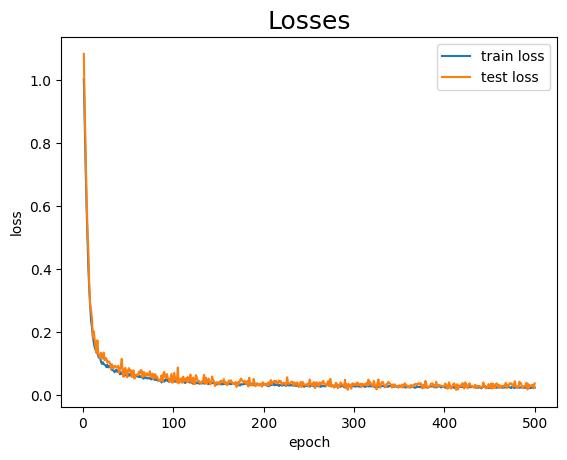

In [11]:
def show_training_result(train_result:TrainResult) -> None:
    assert len(train_result.test_losses) == len(train_result.test_losses)
    X:list[float] = [float(i) for i in range(1, len(train_result.test_losses) + 1)]
    plt.plot(X, train_result.train_losses, label='train loss')
    plt.plot(X, train_result.test_losses, label='test loss')
    plt.title("Losses", fontsize=18)
    plt.xlabel("epoch")
    plt.ylabel("loss")
    plt.legend()
    plt.show()

train_res_path:str = f"./Models/train_result_epoch{499}.txt"
file = open(train_res_path, "r")
train_result:TrainResult = TrainResult.from_json(file.read())
file.close()
show_training_result(train_result)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-3.5224643..3.3164814].


noisy image : 


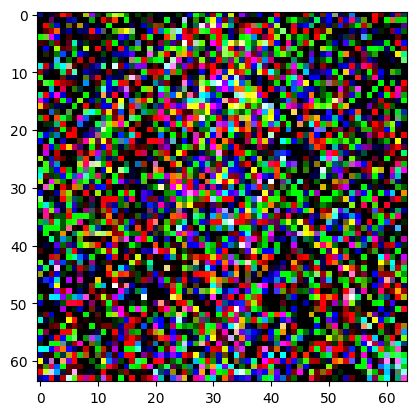

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-3.7589364..4.1028585].


noise : 


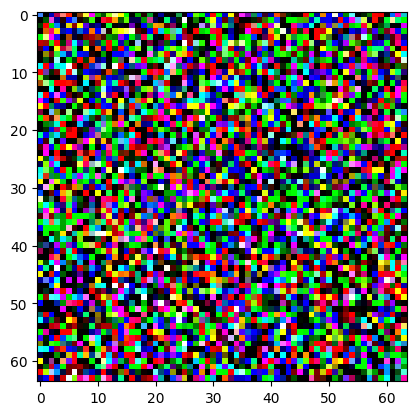

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-3.799053..4.0347195].


predicted noise: 


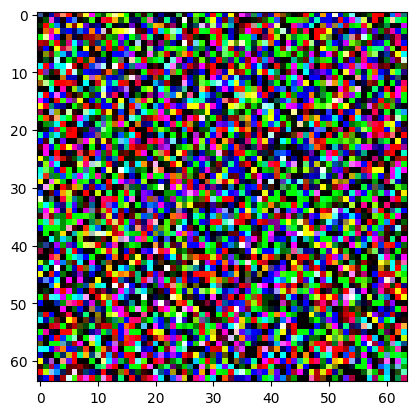

In [13]:
def test_model(diffusion_model:DiffusionModel, test_size:int) -> None:
    with torch.no_grad():
        x0:torch.Tensor = torch.stack([dataset[random.randint(0, len(dataset) - 1)] for _ in range(0, test_size)])
        t:torch.Tensor = torch.randint(0, diffusion_model.timesteps, (test_size,))
        xt, noise = diffusion_model._add_noise(x0, t)
        t = t.float().to(diffusion_model.device)
        pred_noise:torch.Tensor = diffusion_model.model(xt, t)

        for i in range(0, test_size):
            print("noisy image : ")
            plt.imshow(xt[i].cpu().permute(1, 2, 0))
            plt.show()

            print("noise : ")
            plt.imshow(noise[i].cpu().permute(1, 2, 0))
            plt.show()

            print("predicted noise: ")
            plt.imshow(pred_noise[i].cpu().permute(1, 2, 0))
            plt.show()

denoiser:UNet = load_denoiser("denoiser_epoch499.model")
diffusion_model:DiffusionModel = DiffusionModel(denoiser, None, None, timestep, device)
test_model(diffusion_model, 1)

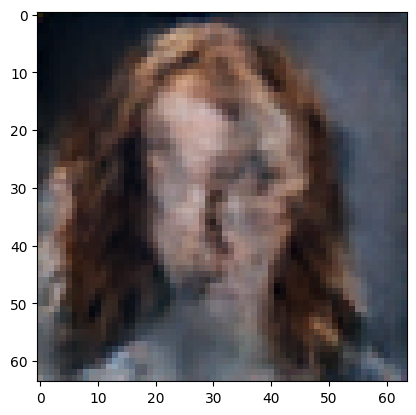

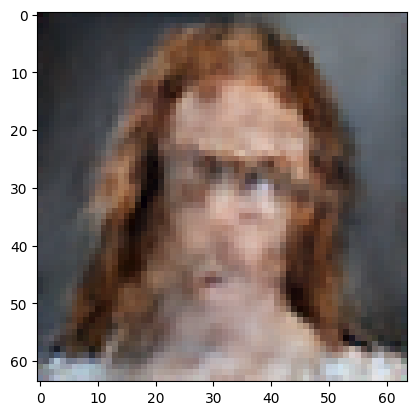

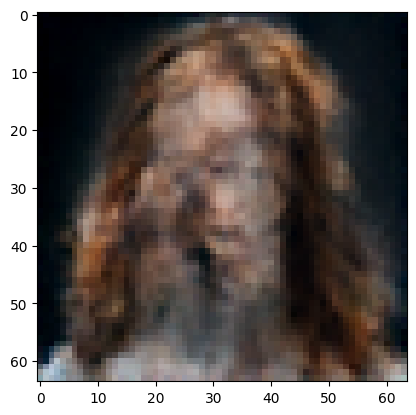

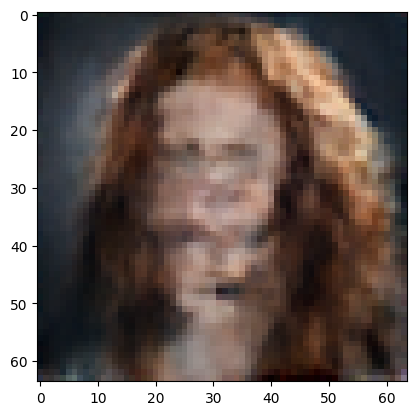

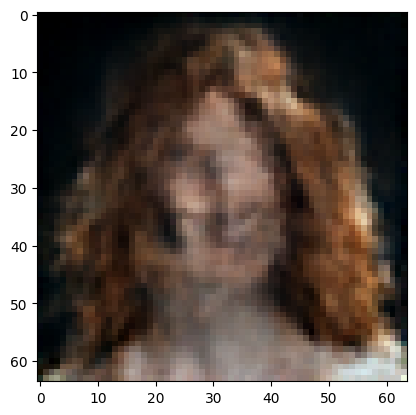

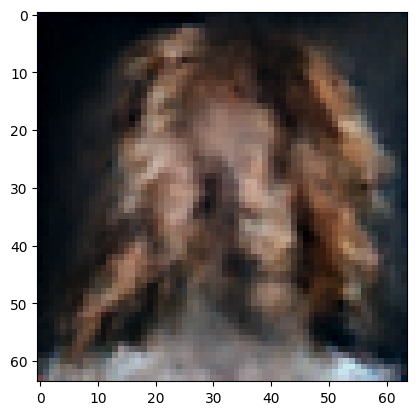

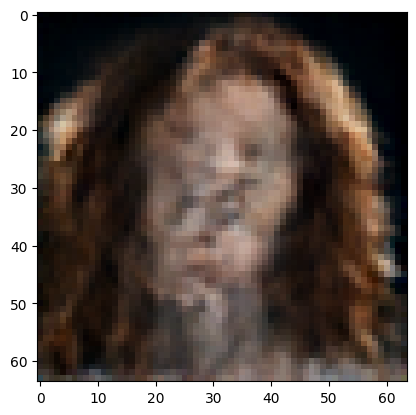

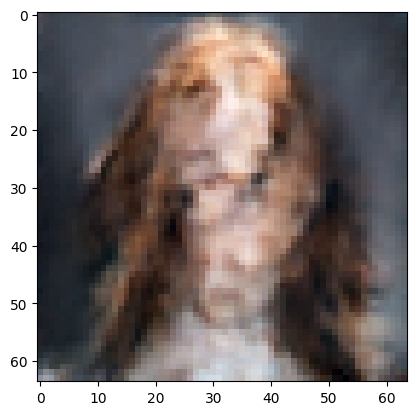

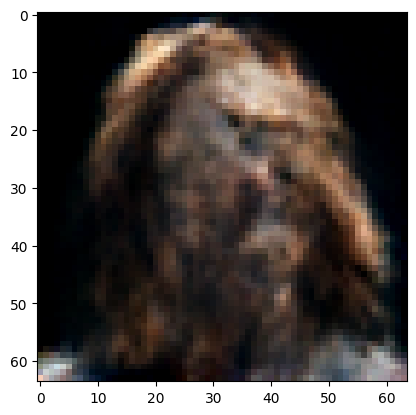

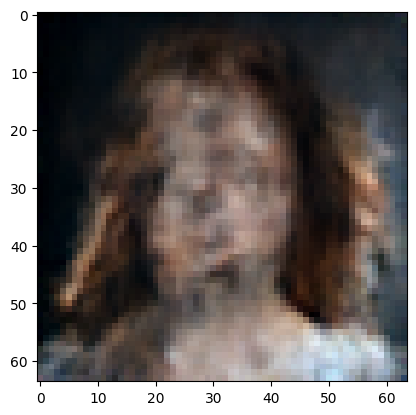

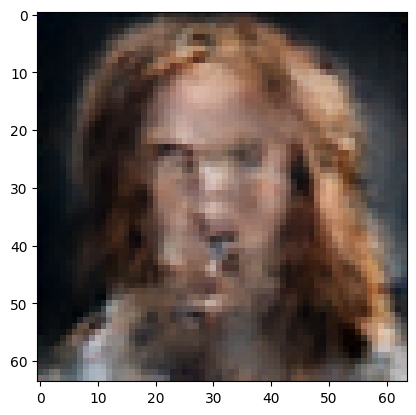

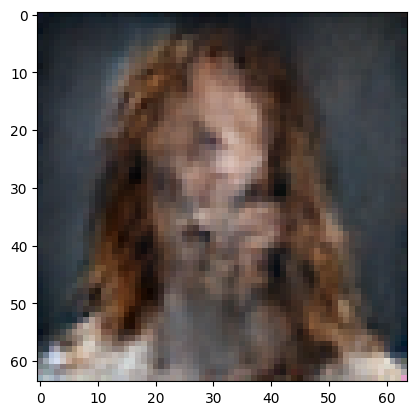

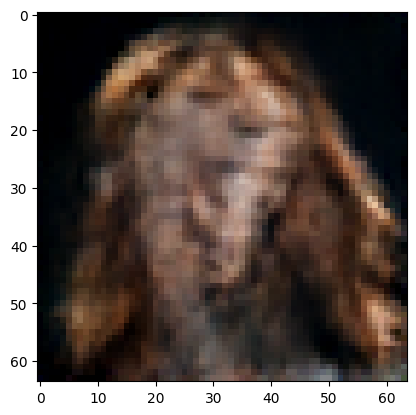

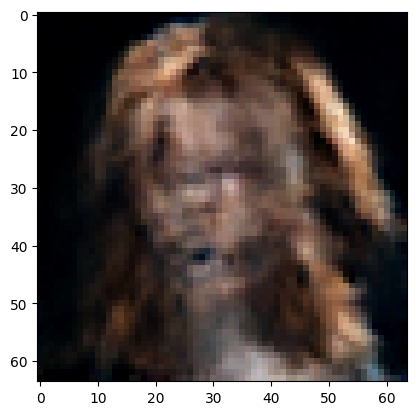

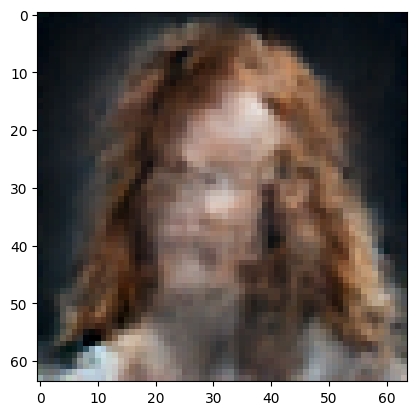

In [ ]:
denoiser_name:str = "denoiser_epoch499.model"
img_prefix:str = "v0.1"
denoiser:UNet = load_denoiser(denoiser_name)

diffusion_model:DiffusionModel = DiffusionModel(denoiser, None, None, timestep, device)
samples:int = 15
images:torch.Tensor = diffusion_model.sample(samples, verbose=False)
for i in range(0, images.shape[0]):
    img:torch.Tensor = images[i].permute(1, 2, 0)
    plt.imshow(img)
    plt.show()

save_image:bool = False
if save_image:
    base_path:str = "./GeneratedImages"
    for i in range(0, images.shape[0]):
        now:datetime = datetime.now()
        local_path:str = f"{img_prefix}_{now.year}_{now.month}_{now.day}_{now.hour}_{now.minute}_{now.second}_{now.microsecond}_{denoiser_name}"
        img_path:str = os.path.join(base_path, f"{local_path}.png")
        torchvision.utils.save_image(images[i], img_path)